# DSxH 2324 Assignment 1: Prediction of Length Of Stay in ICU

# Introduction

We will work with the [**MIMIC-III Clinical Database Demo**](https://physionet.org/content/mimiciii-demo/1.4/) which contains all intensive care unit (ICU) stays for 100 patients (randomly selected from the subset of patients in the dataset who eventually die).
The main task is to predict the Length Of Stay (LOS) in the ICU using different strategies: (1) using the severity of illness score OASIS, and (2) using all the
variables.

#### OASIS

The Oxford Acute Severity of Illness Score (OASIS) is based on the following variables: age, elective surgery, prior length of stay (LOS) and seven physiologic measurements: Glasgow Coma Score (GCS), heart rate, mean arterial pressure (MAP), respiratory rate, temperature, urine output, ventilated. For each variable, the worst score across the first day in ICU should be used to tabulate OASIS.

See [here](https://alistairewj.github.io/project/oasis/) for more information.

**Observation**: The concept of *elective surgery* is where a patient is admitted to the intensive care unit either in routine preparation for a planned surgery or for stabilization after completion of a planned surgery. Elective surgery is an important covariate for many risk adjustments as patients who are admitted to the ICU for planned surgeries tend to be healthier than their counterparts.


# Exercise 1:

Predict if the length of stay (LOS) of the ICU patients are "short" or "long" (binary classification problem) based on the severity score OASIS of the first 24 hours (and 48 hours) of an ICU stay.


## Instructions for the exercise 1



- We provide you the variables already computed and saved in csv files, except age, elective surgery, pre-LOS and temperature.

- In order to compute the age and pre-LOS and consult the elective surgery information you need to merge tables PATIENTS, ADMISSIONS and ICUSTAYS.
    - You should compute the age at the time the patient is admitted to the ICU from *date of birth*, 'dob' from PATIENTS table, then you can drop dob from the dataframe.
    - For the pre-LOS you should compare 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.
    - The elective surgery information is stored in the column 'admission_type' of PATIENTS, ADMISSIONS and ICUSTAYS table.

- You need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure.
    - The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so you have to look for the different labels.
    - You can use pandas.DataFrame.loc to look for the itemid corresponding to labels of the temperature in D_ITEMS table. If you do not know the exact label you are looking for, you can look for the strings in column label containing 'Temperature' using pandas.Series.str.contains as follows:
    > df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]


- Once you have computed these variables you can read the rest of variables, provided in the csv files, and merge them into a single dataframe to pass it to the OASIS function (see [here](https://gist.github.com/tompollard/d4c216d0c4ad30481c99)) and compute the severity score.


- The Glasgow Coma Scale is stored in a different way in Metavision and Carevue.
    - Metavision saves the three tests separately: GCS - Eye Opening,  GCS - Motor Response, GCS - Verbal Response
    - Carevue saves a single test: GCS_total.
    - We provide you 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and  GCS_total_carevue.csv
    - You should concatenate the values and keep the worst one which corresponds to the minimum score.


- Each csv file contains a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for the ventilation which just contains:  [subject_id, hadm_id, icustay_id, variable_Time], since the important information is if there is ventilation or not (YES or NO) and when has been installed.


- Normalize the measures time. Use intime, which provides the date and time the patient was transferred into the ICU, as the reference value to compute the time that has passed since then until the variable measurement were taken.

- After the normalization, you can filter the instances to keep the ones of the first 24 hours (or 48 hours) as observations to compute the OASIS score.
    - Try to different strategies:
        - All the instances of the first 24 hours.
        - All the instances of the first 48 hours.

- For the prediction, consider the following binary label:
    - LOS < 4: short stay
    - Otherwise: long stay.
    
- Use Random forest to classify using a 5-fold cross validation.

- As can be seen in the code to compute OASIS, the score is NaN if any of the considered variables has all its instances as NaN. MIMIC-III has many NaN values and the demo subset is more limited in the number. So, the number of samples with OASIS different of NaNs considering first 24h is just 8. You can use the first 48h but the number is also very limited and the performance of the proposed classifier will be very poor.

- We suggest that you also try an alternative to compute the OASIS score.
    - You can change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN. For that use np.nansum instead of using sum in the line:
        > oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,oasis_temp, oasis_urine, oasis_vent, oasis_surg]).
   
- Show the number of NaN values of OASIS for the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h).
    
- Analyze the results of the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h):
    - Compare the mean accuracy
    - Build the confusion matrix



## Solution Exercise 1

### Imports and Loading of Data

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Download the MIMIC-III Clinical Database Demo can be download from [here](https://physionet.org/content/mimiciii-demo/1.4/) and copy the csv files in a 'data' folder.


In [49]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/_Universität_HPI/Semester 6/DSxHealth/Assignments/Assignment 1/data/" #path to my data folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df_patients = pd.read_csv(path+ 'PATIENTS.csv')
df_admissions = pd.read_csv(path+ 'ADMISSIONS.csv')
df_icustays = pd.read_csv(path+ 'ICUSTAYS.csv')

In [51]:
print(df_patients.columns)
print(df_admissions.columns)
print(df_icustays.columns)

Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag'],
      dtype='object')
Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')
Index(['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource',
       'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid',
       'intime', 'outtime', 'los'],
      dtype='object')


In [52]:
df_admissions['admission_type'].unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT'], dtype=object)

In [53]:
df_icustays.shape

(136, 12)

In [54]:
df_patients = df_patients[['subject_id','dob']]
df_admissions = df_admissions[['subject_id','hadm_id', 'admittime', 'admission_type']]
df_icustays = df_icustays[['subject_id','hadm_id', 'icustay_id', 'intime', 'los']]

In [55]:
print(df_patients.columns)
print(df_admissions.columns)
print(df_icustays.columns)

Index(['subject_id', 'dob'], dtype='object')
Index(['subject_id', 'hadm_id', 'admittime', 'admission_type'], dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'intime', 'los'], dtype='object')


### Merging Data

In [56]:
df_merged = pd.merge(df_admissions, df_patients, on='subject_id', how='left')
admissions_complete = pd.merge(df_merged, df_icustays, on=['subject_id', 'hadm_id'], how='left')

# Making sure the date columns are in the correct datetime format
admissions_complete['dob'] = pd.to_datetime(admissions_complete['dob'])
admissions_complete['admittime'] = pd.to_datetime(admissions_complete['admittime'])
admissions_complete['intime'] = pd.to_datetime(admissions_complete['intime'])

### Overview of required Variables


We need the following variables for the calculation of the OASIS-score:
  - Pre-ICU LOS (in h)
  - Age (in years)
  - GCS
  - Heart Rate
  - MAP
  - Respiratory Rate
  - Temparature
  - Urine Output
  - Ventilated (yes or no)
  - Elective Surgery (yes or no)
  

### Calculating Age, Pre-Los and Elective Surgery

In [57]:

# Caluclating the age at admission

admissions_complete['age'] = admissions_complete['intime'].dt.year - admissions_complete['dob'].dt.year
# Because the anonymised age for patients above 89 years old, we replace it with a 90, since the OASIS formular does not differentiate between the ages from above 90 years old
admissions_complete['age'] = admissions_complete['age'].apply(lambda x: x if x < 90 else 90)

admissions_complete = admissions_complete.drop(['dob'],axis=1)

In [58]:
#Calculating the pre-LOS in hours (pre-ICU-Length-Of-Stay-Time)
admissions_complete['prelos'] = (admissions_complete['intime'] - admissions_complete['admittime']).dt.total_seconds() / 3600

In [59]:
# The elective surgery information is already found in the admission_type column
admissions_complete['admission_type'].unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT'], dtype=object)

### Temperature

In [60]:
# Importing data
df_chartevents = pd.read_csv(path+ 'CHARTEVENTS.csv')
df_items = pd.read_csv(path+'D_ITEMS.csv')

<ipython-input-60-32f680bcf39d>:2: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chartevents = pd.read_csv(path+ 'CHARTEVENTS.csv')


We are only interested in the values with labels starting with "Temperature F..." or "Temparture C...". So Temperature C, Temperature C (calc), Temperature F, Temperature F (calc), Temperature Fahrenheit, Temperature Celsius. With the first three being from the carevue database and the last two from the metavision base.

In [61]:
df_chartevents = df_chartevents[['subject_id','hadm_id','icustay_id','itemid','charttime','value','valuenum','valueuom']]
df_items = df_items[['itemid','label']]
df_charts_events = pd.merge(df_chartevents,df_items,how='left',on=['itemid'])

In [62]:

import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)


def convert_fahrenheit_to_celsius(temperature, unit):
    #Convert temperature from Fahrenheit to Celsius if needed
    if pd.isna(temperature) or not isinstance(unit, str):
        return np.nan
    if 'F' in unit:
        return (5/9) * (temperature - 32)
    return temperature

def process_temperature_data(charts_events_df):
    # Filter temperature-related records, excluding 'Temperature Site'
    is_temperature = charts_events_df['label'].str.contains('^Temperature', case=False, regex=True)
    filtered_temps = charts_events_df[is_temperature & (charts_events_df['label'] != 'Temperature Site')]

    # Convert temperatures to Celsius and create a new column
    filtered_temps.loc[:, 'temp_c'] = [convert_fahrenheit_to_celsius(row['valuenum'], row['valueuom']) for _, row in filtered_temps.iterrows()]
    #filtered_temps.loc[:, 'temp_c'] = [convert_fahrenheit_to_celsius(row['valuenum'], row['valueuom']) for _, row in filtered_temps.iterrows()]
    #filtered_temps['temp_c'] = [ convert_fahrenheit_to_celsius(row['valuenum'], row['valueuom']) for _, row in filtered_temps.iterrows()]
    return filtered_temps

def compute_hours_since_admission(merged_data):
    #Compute the hours since each patient was admitted to ICU
    time_diff = pd.to_datetime(merged_data['charttime']) - pd.to_datetime(merged_data['intime'])
    merged_data['hours_since_admission'] = time_diff.dt.total_seconds() / 3600

def get_temperature_data(period_hours, admissions_df, charts_events_df):
    #Process temperature data and merge with the main patient dataframe
    # Refine and filter the temperature data
    refined_temperature_data = process_temperature_data(charts_events_df)

    # Merge the refined temperature data with the main patient data
    merged_data = pd.merge( admissions_df, refined_temperature_data,  how='left',  on=['subject_id', 'hadm_id', 'icustay_id'])

    # Compute the time since ICU admission and filter records based on the provided time frame
    compute_hours_since_admission(merged_data)
    filtered_data = merged_data[(merged_data['hours_since_admission'] <= period_hours) & (merged_data['hours_since_admission'] > 0)]

    return filtered_data[['subject_id', 'icustay_id', 'temp_c']]


### Time Normalization and Filter Function

The following is the function to first normalize the time and to then filter out all values outside of the specified timeframe, for the later distinction between 24h and 48h values.

In [63]:
import pandas as pd  # Ensure pandas is still imported

def normalize_time(df, time_column, admission_time_column):
    # Calculate the time difference in hours
    time_diff = (pd.to_datetime(df[time_column]) - pd.to_datetime(df[admission_time_column])).dt.total_seconds() / 3600
    df['hours_since_intime'] = time_diff
    return df

def filter_time_period(period_hours, admissions_df, secondary_df, time_column, value_column):
    # Merge admissions data with secondary data on patient and admission identifiers
    merged_df = pd.merge(admissions_df, secondary_df, how='left', on=['subject_id', 'hadm_id', 'icustay_id'])
    # Normalize the time difference between measurement and ICU admission time
    normalized_df = normalize_time(merged_df, time_column, 'intime')
    # Filter records where the measurement was taken within the specified period and after ICU admission
    filtered_df = normalized_df[(normalized_df['hours_since_intime'] <= period_hours) & (normalized_df['hours_since_intime'] > 0)]
    # Return the relevant columns
    return filtered_df[['subject_id', 'icustay_id', value_column]]


### Glasgow Coma Scale

In [64]:
df_GCS_total_carevue = pd.read_csv(path+"../variables/GCS_total_carevue.csv",index_col=0)
df_GCS_total_carevue = df_GCS_total_carevue.rename(columns={'GCS_total_Carevue_Time': 'Time', 'GCS_total_Carevue': 'GCS_total'})
df_GCS_E_metavision = pd.read_csv(path+ '../variables/GCS_E_metavision.csv',index_col=0)
df_GCS_E_metavision = df_GCS_E_metavision.rename(columns={'GCS_E_Time': 'Time'})
df_GCS_M_metavision = pd.read_csv(path+ '../variables/GCS_M_metavision.csv',index_col=0)
df_GCS_M_metavision = df_GCS_M_metavision.rename(columns={'GCS_M_Time': 'Time'})
df_GCS_V_metavision = pd.read_csv(path+ '../variables/GCS_V_metavision.csv',index_col=0)
df_GCS_V_metavision = df_GCS_V_metavision.rename(columns={'GCS_V_Time': 'Time'})

# Merge the metavision dataframes into one and calculate the combined value
df_GCS_total_metavision = pd.merge(df_GCS_E_metavision,pd.merge(df_GCS_M_metavision,df_GCS_V_metavision,on=["subject_id","hadm_id","icustay_id","Time"]))
df_GCS_total_metavision['GCS_total'] = df_GCS_total_metavision['GCS_E']+df_GCS_total_metavision['GCS_M']+df_GCS_total_metavision['GCS_V']
df_GCS_total_metavision = df_GCS_total_metavision.drop(['GCS_E','GCS_M','GCS_V'],axis=1)

# Concatenate Both into one dataframe
df_GCS = pd.concat([df_GCS_total_metavision, df_GCS_total_carevue])

### Urine

For the Urine Output the sum has to be summed up over the entire period

In [65]:
df_urine = pd.read_csv(path+ '../variables/urine.csv',index_col=0)

In [66]:
def get_urine(period_hours, admissions_df, urine_df):

    # Filter records within the specified time frame
    filtered_urine_records= filter_time_period(period_hours, admissions_df, df_urine, 'urine_Time', 'urine')

    # Summarize urine output for each icustay_id
    summary_df = (filtered_urine_records.groupby(['subject_id', 'icustay_id']).agg(total_urine=('urine', 'sum')).reset_index())

    # Now adjusting for the daily output per day, since otherwise the 48h time span doubles the values
    summary_df['urine'] = summary_df['total_urine'] * (24 / period_hours)
    summary_df = summary_df[['subject_id','icustay_id', 'urine']]

    return summary_df

### Heart rate, Respiratory rate, MAP

In [67]:
df_heartrate = pd.read_csv(path+ '../variables/heartRate.csv',index_col=0)
df_respiratoryrate = pd.read_csv(path+ '../variables/RespiratoryRate.csv',index_col=0)
df_map = pd.read_csv(path+ '../variables/MAP.csv',index_col=0)

### Ventilation

Here we just need a Boolean if the ventilation has ever been turned on within the given timeframe

In [68]:
def get_ventilation(period_hours):
    df_ventilation = pd.read_csv(path+ '../variables/ventilation.csv',index_col=0)
    df_ventilation['ventilated'] = 'y'
    df_ventilation = filter_time_period(period_hours, admissions_complete, df_ventilation, 'starttime', 'ventilated')
    df_ventilation = pd.merge(admissions_complete,df_ventilation,how='left',on=['subject_id','icustay_id'])
    df_ventilation['ventilated'] = df_ventilation['ventilated'].fillna('n')
    df_ventilation = df_ventilation[['subject_id','icustay_id','ventilated']]
    df_ventilation = df_ventilation.drop_duplicates()



   # Only keeping the relevant features
    return df_ventilation

### OASIS Calculation Function

In [69]:
# The MIT License

# Copyright (c) 2015 Tom Pollard

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

def compute_oasis(pd_dataframe, allow_NaN =False):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute
    Severity of Illness Score (OASIS) (http://oasisicu.com/)

    The DataFrame should include only measurements taken over the first 24h
    from admission. pd_dataframe should contain the following columns:

    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency)

    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale
    using a subset of Acute Physiology And Chronic Health Evaluation
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """

    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan
    # Return sum
    if allow_NaN:
        oasis_score = np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
            oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    else:
        oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
            oasis_temp, oasis_urine, oasis_vent, oasis_surg])

    return oasis_score

### Data preparation function

In [70]:
def prepare_data(addmissions_dataframe,period_hours ,allowNaN):
    # Das wo am Ende alles reinkommt
    final_with_OASIS = pd.DataFrame()

    final_df = addmissions_dataframe[['icustay_id', 'subject_id', 'los', 'age', 'prelos', 'admission_type']]

    # Die Dinger wonach es aufgebaut wird
    final_temp = get_temperature_data(period_hours, addmissions_dataframe, df_charts_events)
    final_GCS = filter_time_period(period_hours, addmissions_dataframe, df_GCS, 'Time', 'GCS_total')
    final_heartrate = filter_time_period(period_hours, addmissions_dataframe, df_heartrate, 'hrate_Time', 'hrate')
    final_map = filter_time_period(period_hours, addmissions_dataframe, df_map, 'MAP_Time','MAP')
    final_respiratory = filter_time_period(period_hours, addmissions_dataframe, df_respiratoryrate, 'resp_rate_Time','resp_rate')
    final_urine = get_urine(period_hours, addmissions_dataframe, df_urine)
    final_ventilation = get_ventilation(period_hours)

    final_df = pd.concat([final_df,final_temp])
    final_df = pd.concat([final_df,final_GCS])
    final_df = pd.concat([final_df,final_heartrate])
    final_df = pd.concat([final_df,final_map])
    final_df = pd.concat([final_df,final_respiratory])
    final_df = pd.concat([final_df,final_urine])
    final_df = pd.concat([final_df,final_ventilation])
    final_df = final_df.drop(['subject_id'],axis=1)


    # Dann durch iterieren und alle hingeben
    for icu_id in addmissions_dataframe.icustay_id.unique():
        filtered_final_df = final_df[final_df['icustay_id'] == icu_id]
        los_value = float(filtered_final_df['los'].dropna().unique()[0])
        final_with_OASIS = pd.concat([final_with_OASIS, pd.DataFrame({'icustay_id':[icu_id],'oasis':[compute_oasis(filtered_final_df,allowNaN)],'los':los_value})])

    final_with_OASIS['los'] = np.where(final_with_OASIS['los']<4, 0, 1)
    return final_with_OASIS

### Creating the training data

In [71]:
data24 = prepare_data(admissions_complete, 24, True)
data48 = prepare_data(admissions_complete, 48, True)
data48NaN = prepare_data(admissions_complete, 48, False)

In [72]:
print(data24.shape,data48NaN.shape,data48.shape)

(136, 3) (136, 3) (136, 3)


### Analysis of NaN Values in the created training data

In [73]:
nan_count_24 = data24['oasis'].isna().sum()
nan_count_48NaN = data48NaN['oasis'].isna().sum()
nan_count_48 = data48['oasis'].isna().sum()

print(f"Number of NaNs in 'oasis' column in data24: {nan_count_24}")
print(f"Number of NaNs in 'oasis' column in data48NaN: {nan_count_48NaN}")
print(f"Number of NaNs in 'oasis' column in data48: {nan_count_48}")


Number of NaNs in 'oasis' column in data24: 0
Number of NaNs in 'oasis' column in data48NaN: 83
Number of NaNs in 'oasis' column in data48: 0


### Model Training and Predcition

In [74]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_report_model(df):
    # Drop rows with NaN values
    df = df.dropna(subset=['oasis'])

    # Split data into features and target
    X = df[['oasis']]  # Features
    y = df['los']  # Target

    # Define the cross-validator
    cv = StratifiedKFold(n_splits=5)

    # Define a pipeline that handles imputation and then fits the model
    pipeline = make_pipeline(SimpleImputer(strategy='mean'), RandomForestClassifier())

    # Parameters for GridSearch
    param_grid = {
        'randomforestclassifier__n_estimators': [10, 50, 100],
        'randomforestclassifier__max_depth': [None, 5, 10],
        'randomforestclassifier__min_samples_split': [2, 4],
        'randomforestclassifier__min_samples_leaf': [1, 2]
    }

    # Define scoring metrics
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, zero_division=0),
               'recall': make_scorer(recall_score),
               'f1': make_scorer(f1_score)}

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit='f1', return_train_score=False)

    # Fit the grid search and print the best parameters
    grid_search.fit(X, y)
    # Line for printing out the chosen hyperparamater
    #print(f"Best parameters: {grid_search.best_params_}")

    # Extract the best estimator
    best_pipeline = grid_search.best_estimator_

    # Print out the average scores using best estimator
    best_cv_results = cross_validate(best_pipeline, X, y, cv=cv, scoring=scoring)
    print(f"Average accuracy: {np.mean(best_cv_results['test_accuracy'])}")
    print(f"Average precision: {np.mean(best_cv_results['test_precision'])}")
    print(f"Average recall: {np.mean(best_cv_results['test_recall'])}")
    print(f"Average F1-score: {np.mean(best_cv_results['test_f1'])}")

    # For the confusion matrix, compile predictions from each fold using the best estimator
    y_true, y_pred = [], []
    for train_ix, test_ix in cv.split(X, y):
        # Fit the model on the train segment
        best_pipeline.fit(X.iloc[train_ix], y.iloc[train_ix])
        # Predict on the test segment
        y_true.extend(y.iloc[test_ix])
        y_pred.extend(best_pipeline.predict(X.iloc[test_ix]))

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Results of the Model using the timespan of 24 hours and the modified OASIS score calculation allowing NaNs:
Average accuracy: 0.706084656084656
Average precision: 0.4416666666666666
Average recall: 0.16785714285714284
Average F1-score: 0.21080808080808083


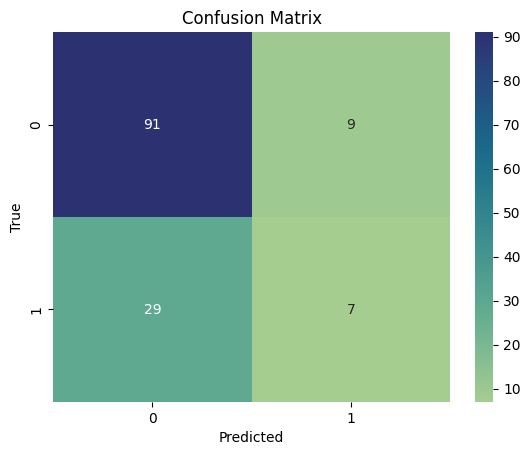

In [75]:
print("Results of the Model using the timespan of 24 hours and the modified OASIS score calculation allowing NaNs:")
train_and_report_model(data24)

Results of the Model using the timespan of 48 hours and the original OASIS score calculation not allowing NaNs:
Average accuracy: 0.5272727272727272
Average precision: 0.4966666666666667
Average recall: 0.35
Average F1-score: 0.3942857142857143


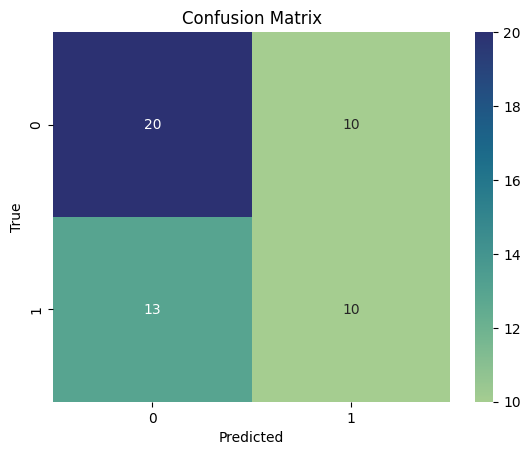

In [76]:
print("Results of the Model using the timespan of 48 hours and the original OASIS score calculation not allowing NaNs:")
train_and_report_model(data48NaN)

Results of the Model using the timespan of 48 hours and the modified OASIS score calculation allowing NaNs:
Average accuracy: 0.6616402116402117
Average precision: 0.2533333333333333
Average recall: 0.13571428571428573
Average F1-score: 0.17487179487179486


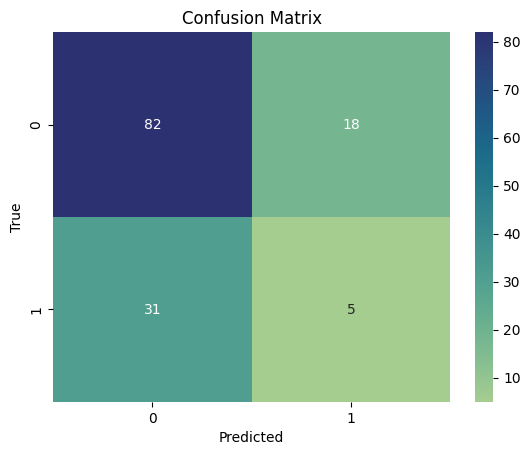

In [77]:
print("Results of the Model using the timespan of 48 hours and the modified OASIS score calculation allowing NaNs:")
train_and_report_model(data48)

### Summary of Results

In this case the classifier with the highest accuracy was the RandomForest trained on the 24 hour data with 70% closely followed by the on for 48 hours with both using the OASIS formular allowing NaN values in the calculation and the other being way lower with only and accuracy of 52%, which makes a sense since without allowin NaNs the dataset is less than half the size since 83 of 136 instances are missing. So here the highest achieved accuracy by a RandomForest classifier was 70%.

# Exercise 2:


## Intructions Exercise 2



1. Compute:
    - the number of different patients in the dataset
    - the number of different hospital admissions in the dataset
    - the number of different icu stays in the dataset
2. Show with an example that we can have a patient with more than one icustay.
3. Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue.
4. Compute the number of NaN OASIS values for your different implementations.
5. Explain the difference between 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table.


## Solution Exercise 2

In [78]:
# Exercise 2.1

# Computing of the unique Counts
number_of_patients = df_icustays['subject_id'].nunique()
number_of_admissions = df_icustays['hadm_id'].nunique()
number_of_icu_stays = df_icustays['icustay_id'].nunique()

# Print the results
print(f'Number of different patients: {number_of_patients}')
print(f'Number of different hospital admissions: {number_of_admissions}')
print(f'Number of different ICU stays: {number_of_icu_stays}')


Number of different patients: 100
Number of different hospital admissions: 129
Number of different ICU stays: 136


In [79]:
# Exercise 2.2

# Code for the overview display of all patients with more than one ICU-Stay

#icu_stays_count = df_icustays.groupby('subject_id')['icustay_id'].nunique()
#multiple_icu_stays = icu_stays_count[icu_stays_count > 1]
# Print patients with more than one ICU stay
#print("\nPatients with more than one ICU stay:")
#print(multiple_icu_stays)

# Example of a patient with more than one ICU stay
print("\n Example of the Patient with the subject id of 41976, that actually even has 15 ICU stays:")
df_icustays[df_icustays['subject_id']==41976]


 Example of the Patient with the subject id of 41976, that actually even has 15 ICU stays:


,subject_id,hadm_id,icustay_id,intime,los
80,41976,125449,285272,2198-10-29 06:55:20,2.5803
81,41976,173269,205170,2199-01-13 17:14:16,2.9406
82,41976,176016,286072,2199-01-31 22:27:21,10.7764
83,41976,172082,253931,2200-03-17 20:33:07,10.8625
84,41976,152032,234541,2200-06-09 16:14:42,2.0829
85,41976,130681,265505,2200-10-29 20:46:54,4.9262
86,41976,180546,285353,2201-05-12 10:50:34,1.3352
87,41976,174863,263095,2201-08-10 23:00:55,0.7599
88,41976,125013,213315,2201-09-28 16:48:10,2.9732
89,41976,155297,209797,2201-11-16 23:03:34,2.7361


In [80]:
# Exercise 2.3


# Reloading the ICU stay data for the dbsource columnn
df_icustays_withsource = pd.read_csv(path+ 'ICUSTAYS.csv')


# Revision of ICU Stays by each system
icu_admissions_by_system = df_icustays_withsource.groupby('dbsource')['icustay_id'].nunique()
carevue_stays = icu_admissions_by_system['carevue']
metavision_stays = icu_admissions_by_system['metavision']


# Print the results
print(f'Number of ICU admissions registered by carevue system: {carevue_stays}')
print(f'Number of ICU admissions registered by carevue system: {metavision_stays}')

Number of ICU admissions registered by carevue system: 59
Number of ICU admissions registered by carevue system: 77


In [81]:
# Exercise 2.4

# Calculation of NaN OASIS Values for each implementation
nan_count_24 = data24['oasis'].isna().sum()
nan_count_48NaN = data48NaN['oasis'].isna().sum()
nan_count_48 = data48['oasis'].isna().sum()

# Printing of Results
print(f"Number of NaNs in 'oasis' column in data24: {nan_count_24}")
print(f"Number of NaNs in 'oasis' column in data48NaN: {nan_count_48NaN}")
print(f"Number of NaNs in 'oasis' column in data48: {nan_count_48}")


Number of NaNs in 'oasis' column in data24: 0
Number of NaNs in 'oasis' column in data48NaN: 83
Number of NaNs in 'oasis' column in data48: 0



```
  # Exercise 2.5
```

The difference between the two values from the different tables is that,

* the INTIME column provides the date and time the patient was transferred into the ICU

* the ADMITTIME column provides the date and time the patient was admitted to the hospital

# Exercise 3:



## Instructions Exercise 3

Try to improve the prediction of the length of stay (LOS) of the ICU patients using all available variables (instead of the Oasis score) in the classification model learning a multidimensional decision boundary.

## Solution Exercise 3

In [82]:
addmissions_dataframe = admissions_complete
df_extended_final = data48.copy()
period_hours = 48


# Die Dinger wonach es aufgebaut wird
final_temp = get_temperature_data(period_hours, addmissions_dataframe, df_charts_events)
final_GCS = filter_time_period(period_hours, addmissions_dataframe, df_GCS, 'Time', 'GCS_total')
final_heartrate = filter_time_period(period_hours, addmissions_dataframe, df_heartrate, 'hrate_Time', 'hrate')
#final_map = filter_time_period(period_hours, addmissions_dataframe, df_map, 'MAP_Time','MAP')
final_respiratory = filter_time_period(period_hours, addmissions_dataframe, df_respiratoryrate, 'resp_rate_Time','resp_rate')
final_urine = get_urine(period_hours, addmissions_dataframe, df_urine)
final_ventilation = get_ventilation(period_hours)

In [83]:
df1 = pd.merge(df_extended_final,addmissions_dataframe[['admission_type','icustay_id','age','prelos']],on=['icustay_id'])


final_temp_2 = final_temp.drop(columns=['subject_id'])
worst_temp_per_icustay = final_temp_2.groupby('icustay_id')['temp_c'].max().reset_index()
df2 = pd.merge(df1,worst_temp_per_icustay,on=['icustay_id'])


final_GCS_2 = final_GCS.drop(columns=['subject_id'])
worst_GCS_per_icustay = final_GCS_2.groupby('icustay_id')['GCS_total'].max().reset_index()
df3 = pd.merge(df2,worst_GCS_per_icustay,on=['icustay_id'])

final_heartrate_2 = final_heartrate.drop(columns=['subject_id'])
worst_heartrate_per_icustay = final_heartrate_2.groupby('icustay_id')['hrate'].max().reset_index()
df4 = pd.merge(df3,worst_heartrate_per_icustay,on=['icustay_id'])


final_respiratory_2 = final_respiratory.drop(columns=['subject_id'])
worst_respiratory_per_icustay = final_respiratory_2.groupby('icustay_id')['resp_rate'].max().reset_index()
df5 = pd.merge(df4,worst_respiratory_per_icustay,on=['icustay_id'])


final_ventilation_2 = final_ventilation.drop(columns=['subject_id'])
worst_ventilation_per_icustay = final_ventilation_2.groupby('icustay_id')['ventilated'].max().reset_index()
df6 = pd.merge(df5,worst_ventilation_per_icustay,on=['icustay_id'], how='left')
df6

,icustay_id,oasis,los,admission_type,age,prelos,temp_c,GCS_total,hrate,resp_rate,ventilated
0,206504,33.0,0,EMERGENCY,70,0.020833,37.555599,15.0,104.0,91.0,n
1,232110,24.0,1,EMERGENCY,36,0.033333,37.055599,15.0,110.0,23.0,n
2,264446,38.0,0,EMERGENCY,87,0.033333,38.500002,15.0,113.0,33.0,n
3,204881,22.0,0,EMERGENCY,74,73.558056,36.944444,15.0,104.0,35.0,n
4,228977,45.0,0,EMERGENCY,49,0.015556,36.111111,3.0,92.0,36.0,n
...,...,...,...,...,...,...,...,...,...,...,...
127,286428,27.0,0,EMERGENCY,55,10.275833,37.611111,15.0,122.0,31.0,n
128,217724,57.0,0,EMERGENCY,90,0.015278,37.888889,3.0,106.0,36.0,y
129,239396,56.0,1,EMERGENCY,45,0.008056,38.055556,10.0,118.0,46.0,y
130,238186,25.0,0,EMERGENCY,73,0.027222,36.777778,15.0,74.0,32.0,n


In [84]:
from sklearn.preprocessing import MinMaxScaler

df6_one_hot = pd.get_dummies(df6['admission_type'])
# Join the new columns to original dataframe
df6 = df6.join(df6_one_hot)
# Drop the original 'admission_type' column
df6 = df6.drop('admission_type', axis=1)
df6

df6['ventilated'] = df6['ventilated'].map({'y': 1, 'n': 0})

features = ['oasis', 'age', 'prelos', 'temp_c', 'GCS_total', 'hrate', 'resp_rate']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the features
df6[features] = scaler.fit_transform(df6[features])
df6 = df6.drop(['icustay_id'], axis=1)
#df6 = df6.drop(['oasis'], axis=1)
df6

,oasis,los,age,prelos,temp_c,GCS_total,hrate,resp_rate,ventilated,ELECTIVE,EMERGENCY,URGENT
0,0.478261,0,0.726027,0.005283,0.559638,1.000000,0.336207,1.000000,0,0,1,0
1,0.282609,1,0.260274,0.005320,0.477069,1.000000,0.387931,0.093333,0,0,1,0
2,0.586957,0,0.958904,0.005320,0.715595,1.000000,0.413793,0.226667,0,0,1,0
3,0.239130,0,0.780822,0.224701,0.458713,1.000000,0.336207,0.253333,0,0,1,0
4,0.739130,0,0.438356,0.005267,0.321097,0.000000,0.232759,0.266667,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.347826,0,0.520548,0.035881,0.568805,1.000000,0.491379,0.200000,0,0,1,0
128,1.000000,0,1.000000,0.005266,0.614677,0.000000,0.353448,0.266667,1,0,1,0
129,0.978261,1,0.383562,0.005245,0.642200,0.583333,0.456897,0.400000,1,0,1,0
130,0.304348,0,0.767123,0.005302,0.431190,1.000000,0.077586,0.213333,0,0,1,0


Average Accuracy: 0.7578347578347578
Average Precision: 0.48
Average Recall: 0.24285714285714288
Average F1 Score: 0.31196581196581197


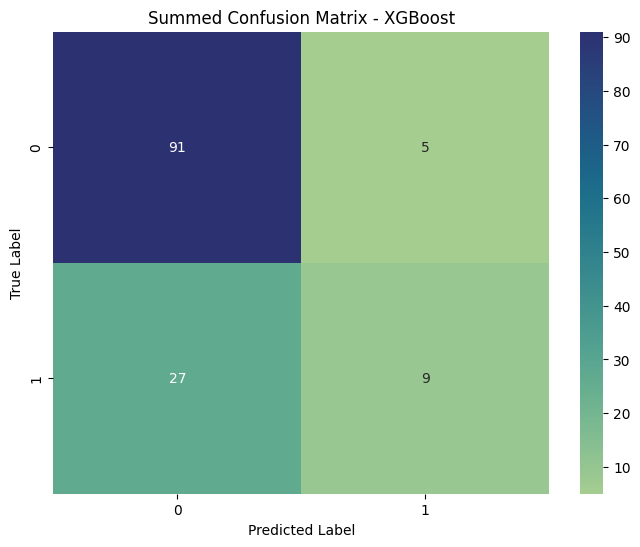

In [85]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Prepare data for classification
X = df6.drop('los', axis=1)  # Features
y = df6['los']  # Target variable

# Set the parameters and model
xgb_params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')

# Prepare for cross-validation
skf = StratifiedKFold(n_splits=5)

# Lists to store metrics and confusion matrices
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

# Conduct the cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_test)

    # Calculate and store the metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Compute and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

# Sum up all confusion matrices
total_cm = np.sum(conf_matrices, axis=0)

# Print out the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1_score}')

# Plot the summed confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='crest')
plt.title('Summed Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Average Accuracy: 0.7122507122507122
Average Precision: 0.4133333333333333
Average Recall: 0.19285714285714287
Average F1 Score: 0.2587101787101787


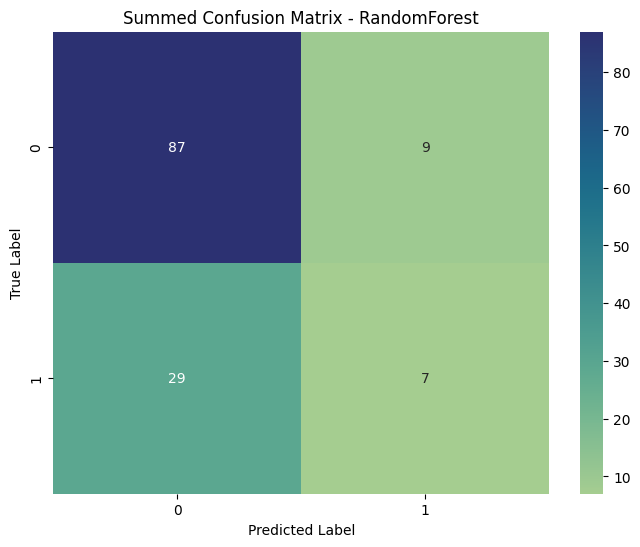

In [86]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define parameters for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=skf, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X, y)

# Best estimator
rf_model = grid_search.best_estimator_

# Lists to store metrics and confusion matrices
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

# Conduct the cross-validation using the best parameters
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model using the best estimator
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate and store the metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Compute and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

# Sum up all confusion matrices
total_cm = np.sum(conf_matrices, axis=0)

# Print out the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1_score}')

# Plot the summed confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='crest')  # Changed the color for distinction
plt.title('Summed Confusion Matrix - RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Average Accuracy: 0.7732193732193732
Average Precision: 0.5866666666666667
Average Recall: 0.2785714285714286
Average F1 Score: 0.37272727272727274


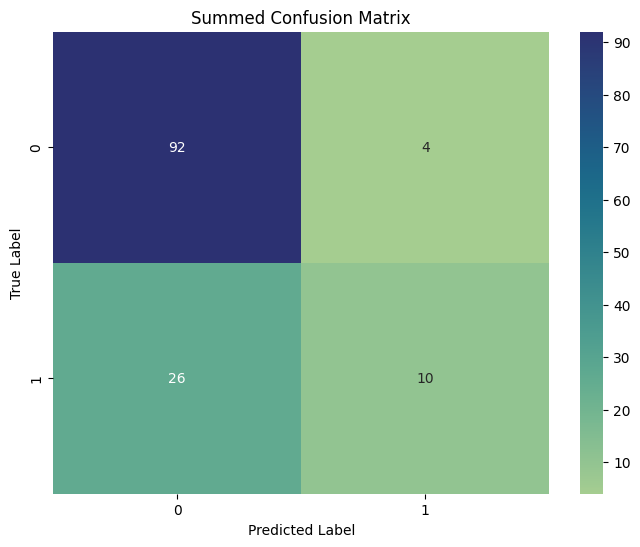

In [87]:
from sklearn.svm import SVC


# Set the parameters and model
params = {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
model = SVC(**params)

# Prepare cross-validation (using StratifiedKFold for balanced splitting)
skf = StratifiedKFold(n_splits=5)

# Lists to store metrics and confusion matrices
accuracies = []
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

# Conduct the cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate and store the metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Compute and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

# Calculate average metrics
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

# Sum up all confusion matrices
total_cm = np.sum(conf_matrices, axis=0)

# Print out the average metrics
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1_score}')

# Plot the summed confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='crest')
plt.title('Summed Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Summary of Results of the third exercise

For this third exercise all the fields of the data related to icu stays were merged into one table ,transformed categorical features into one-hot encoded formats and normalized numerical features to ensure a consistent scale across all variables.
I then also replaced the binary categorical data in the ventilation dataset with numerical equivalents for improved model compatibility.

Afterwards I explored the application of three different model architectures: RandomForestClassifier, Support Vector Machine (SVM), and XGBoost. Each model underwent hyperparameter tuning with cross-validation to determine the optimal settings using Grid Search. I also tried out with dropping the OASIS feature and only using the original values or keeping it and the models performed very slightly better (less than 0.005 difference in accuracy) better with oasis also kept.

The two best models performed with around 76% and 77% accuracy, so an improvement of around 7% from the orignal models form exercise 1 without the additional features. So these models with the more complex hyperdimensional decision boundaries were able to outperform the original models only using the OASIS-score.





